<a href="https://colab.research.google.com/github/mujehoxe/image-registration/blob/main/image_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-modality

In [ ]:
!pip install opencv-python-headless opencv-python scipy matplotlib

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

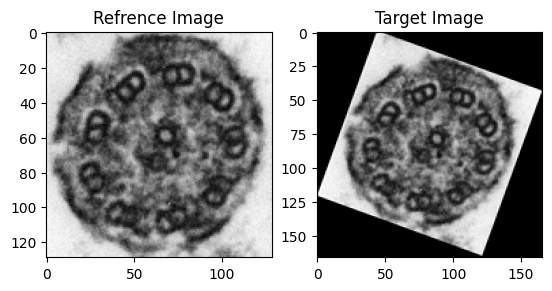

In [4]:
# Source Des Images
# https://commons.wikimedia.org/wiki/File:Bronchiolar_area_cilia_cross-sections_1.jpg
# https://upload.wikimedia.org/wikipedia/commons/a/a8/Bronchiolar_area_cilia_cross-sections_1.jpg

reference = cv2.imread('drive/MyDrive/Colab Notebooks/reference_example.png',
                       cv2.IMREAD_GRAYSCALE)
target = cv2.imread('drive/MyDrive/Colab Notebooks/target_example.png',
                    cv2.IMREAD_GRAYSCALE)

plt.subplot(121), plt.imshow(reference, cmap='gray'), plt.title('Refrence Image')
plt.subplot(122), plt.imshow(target, cmap='gray'), plt.title('Target Image')
plt.show()

In [5]:
# Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create()

target_keypoints, target_descriptors = orb.detectAndCompute(target, None)
reference_keypoints, reference_descriptors = orb.detectAndCompute(reference, None)

In [6]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(target_descriptors, reference_descriptors)

matches = sorted(matches, key=lambda x: x.distance)

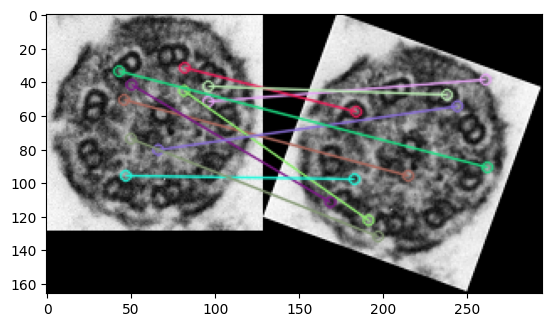

In [7]:
img_matches = cv2.drawMatches(reference,
                              reference_keypoints,
                              target,
                              target_keypoints,
                              matches[:10],
                              None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.show()

In [9]:
points1 = np.float32([target_keypoints[match.queryIdx].pt for match in matches])\
          .reshape(-1,1,2)
points2 = np.float32([reference_keypoints[match.trainIdx].pt for match in matches])\
          .reshape(-1,1,2)

homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

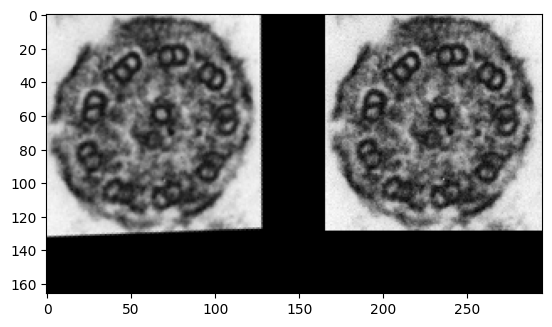

In [10]:
h2, w2 = reference.shape[:2]
h1, w1 = target.shape[:2]

dsize = (w1 + w2, max(h1, h2))

result_image = cv2.warpPerspective(target, homography, dsize)

result_image[0:h2, w1:w1 + w2] = reference

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.show()

# Cross-modality

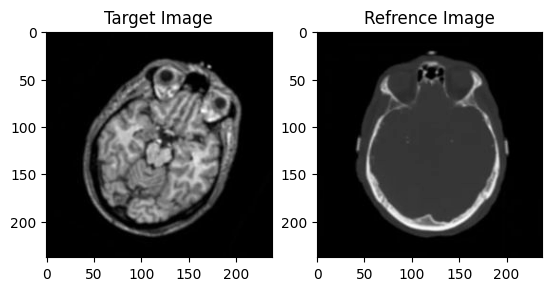

In [11]:
target = cv2.imread('drive/MyDrive/Colab Notebooks/mri_rotated_removed_dots.jpg', cv2.IMREAD_GRAYSCALE)
reference = cv2.imread('drive/MyDrive/Colab Notebooks/ct.jpg', cv2.IMREAD_GRAYSCALE)

plt.subplot(122), plt.imshow(reference, cmap='gray'), plt.title('Refrence Image')
plt.subplot(121), plt.imshow(target, cmap='gray'), plt.title('Target Image')
plt.show()

In [12]:
# Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create()

target_keypoints, target_descriptors = orb.detectAndCompute(target, None)
reference_keypoints, reference_descriptors = orb.detectAndCompute(reference, None)

In [13]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(target_descriptors, reference_descriptors)

matches = sorted(matches, key=lambda x: x.distance)

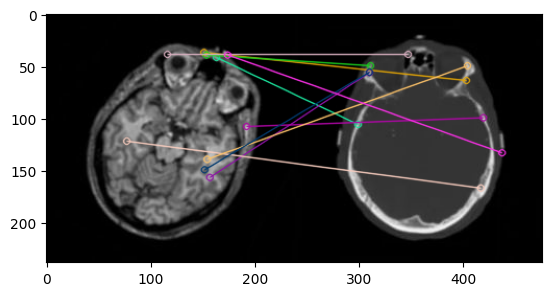

In [14]:
img_matches = cv2.drawMatches(target,
                              target_keypoints,
                              reference,
                              reference_keypoints,
                              matches[:10],
                              None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.show()

In [15]:
points1 = np.float32([target_keypoints[match.queryIdx].pt for match in matches]).reshape(-1,1,2)
points2 = np.float32([reference_keypoints[match.trainIdx].pt for match in matches]).reshape(-1,1,2)

homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

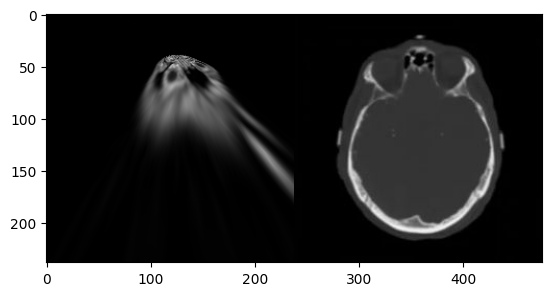

In [16]:
h1, w1 = target.shape[:2]
h2, w2 = reference.shape[:2]

dsize = (w1 + w2, max(h1, h2))

result_image = cv2.warpPerspective(target, homography, dsize)

result_image[0:h2, w1:w1 + w2] = reference

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.show()

Clearly not working

In [17]:
!pip install SimpleITK pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.8 MB/s eta 0:00:00


In [18]:
import SimpleITK as sitk

In [19]:
target = sitk.ReadImage('drive/MyDrive/Colab Notebooks/mri_rotated_removed_dots.jpg')
target = sitk.GetImageFromArray(sitk.GetArrayFromImage(target)[...,0])
target = sitk.Cast(target, sitk.sitkFloat32)
reference = sitk.ReadImage('drive/MyDrive/Colab Notebooks/ct.jpg')
reference = sitk.GetImageFromArray(sitk.GetArrayFromImage(reference)[...,0])
reference = sitk.Cast(reference, sitk.sitkFloat32)

In [20]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])

In [21]:
mi_values = []

def plot_mi(registration_method):
    mi_values.append(registration_method.GetMetricValue())

registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_mi(registration_method))

0

In [22]:
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

In [23]:
initial_transform = sitk.CenteredTransformInitializer(reference,
                                                     target,
                                                     sitk.Euler2DTransform(),
                                                     sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)

In [24]:
final_transform = registration_method.Execute(sitk.Cast(reference, sitk.sitkFloat32),
                                               sitk.Cast(target, sitk.sitkFloat32))


In [25]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(reference)
resampler.SetTransform(final_transform)
resampled_image = resampler.Execute(target)

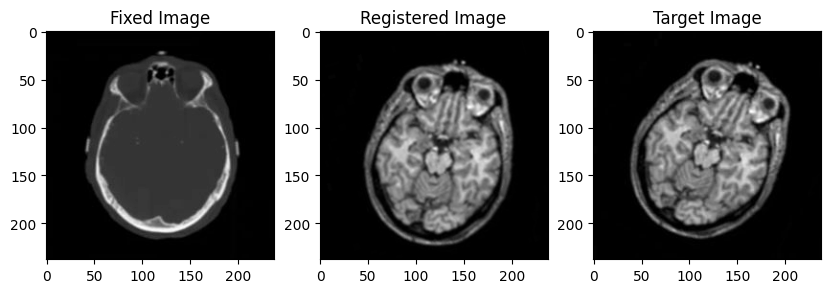

In [26]:
resampled_array = sitk.GetArrayFromImage(resampled_image)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1), plt.title('Fixed Image'), plt.imshow(sitk.GetArrayFromImage(reference), cmap='gray')
plt.subplot(1,3,2), plt.title('Registered Image'), plt.imshow(resampled_array, cmap='gray')
plt.subplot(1,3,3), plt.title('Target Image'), plt.imshow(sitk.GetArrayFromImage(target), cmap='gray')
plt.show()

In [27]:
fixed_image_array = sitk.GetArrayFromImage(reference)
moving_image_array = sitk.GetArrayFromImage(resampled_image)

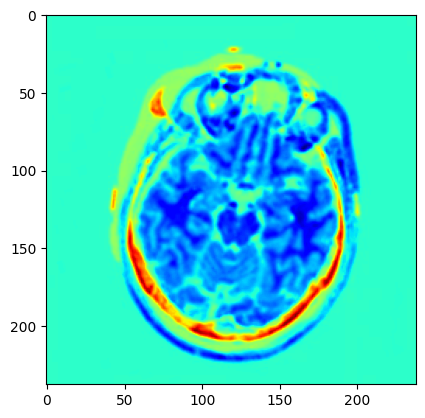

In [28]:
difference_image_array = fixed_image_array - moving_image_array
plt.imshow(difference_image_array, cmap='jet')
plt.show()

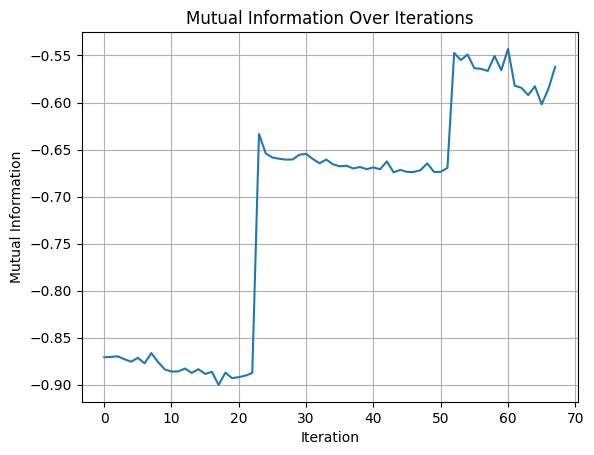

In [29]:
plt.figure()
plt.plot(mi_values)
plt.title('Mutual Information Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.grid(True)
plt.show()